In [3]:
import pennylane as qml
from pennylane import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import torch
import scipy

# Hamiltonian construction

In [4]:
minus_z = np.array([[-1, 0], [0, 1]])
annihilation_fermion_onesite = np.array([[0, 1], [0, 0]])
creation_fermion_onesite = np.transpose(annihilation_fermion_onesite)

def c_operator(flag, node, n_of_nodes): 
    '''
    flag = creation, !flag = annihilation, node = node_index (start from 0,right to left), n_of_nodes = number of nodes
    return: c_node_index operator
    '''
    activator = False
    if node != 0:
        operator = minus_z
    else:
        activator = True
        if flag: operator = creation_fermion_onesite
        else:  operator = annihilation_fermion_onesite
    for i in range(n_of_nodes-1):
        #print(operator)
        if i == node-1:
            activator = True
            if flag: operator = np.kron(creation_fermion_onesite, operator)
            else:  operator = np.kron(annihilation_fermion_onesite, operator)
        elif activator == False:
            operator = np.kron(minus_z, operator)
        elif activator == True:
            operator = np.kron(np.eye(2), operator)
    return operator

In [5]:
def projection_operator(G, node):
    '''
    G: networkx graph, node: node_index (start from 0,right to left)
    return: Projection operator with given node_index 
    '''
    n_of_nodes = len(G.nodes())
    # Deal with exception for periodic
    if node == -1:
        node = n_of_nodes - 1
    if node >= n_of_nodes:
        node = node - n_of_nodes
    
    neighbors = [n for n in G[node]]
    projection = np.eye(2**n_of_nodes)
    #it = 0
    for i in neighbors:
        projection = projection*(np.eye(2**n_of_nodes) - (c_operator(True, i, n_of_nodes)@c_operator(False, i, n_of_nodes)))
    return projection

In [6]:
def generate_hamiltonian(G):
    '''
    G: networkx graph, node: node_index (start from 0,right to left)
    return: Hamiltonian matrix
    '''
    Hamiltonian = 0
    n_of_nodes = len(G.nodes())
    for i in range(n_of_nodes):
        Hamiltonian += projection_operator(G, i)
        
    for k in range(n_of_nodes):
        for j in G[k]:
            Hamiltonian = Hamiltonian + projection_operator(G, k)@c_operator(True, k, n_of_nodes)@c_operator(False, j, n_of_nodes)@projection_operator(G, j)
            
    return Hamiltonian

In [7]:
def number_statevector(n,k):
    bitstrings = ["".join(seq) for seq in itertools.product("01", repeat=n)]
    number_strings = [string for string in bitstrings if string.count('1')==k]
    number_indices = [int(string,2) for string in number_strings]
    vector = np.zeros(2**n)
    vector[number_indices] = 1
    vector = vector / np.sqrt(len(number_indices))
    
    return number_strings, number_indices, vector

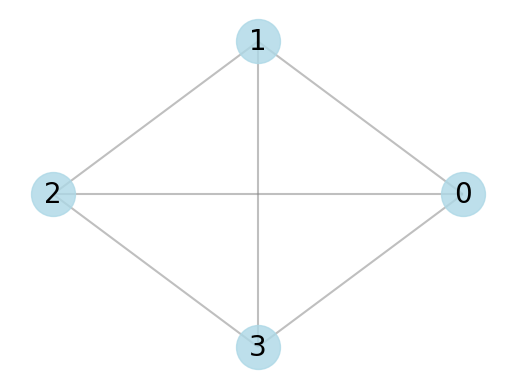

In [8]:
num_qubits = 4 # edit number of qubit
G = nx.Graph()

# Add nodes to the graph with weights using add_nodes_from
nodes = list(zip(range(num_qubits), [1.]*num_qubits))

for (node,w) in nodes:
    #print(node, w)
    G.add_node(node, weight=w)

# Add edges
#edges = [(i,(i+1)%num_qubits) for i in range(num_qubits)]
#edges = [(0,1),(0,4),(1,2),(1,5),(2,3),(2,6),(3,0),(3,7),(4,5),(5,6),(6,7),(7,4)] #8node
#edges = [(0,1),(0,2),(0,4),(0,5),(1,2),(1,3),(1,5),(2,3),(2,4),(3,4),(3,5),(4,5)] #6node
#edges = [(0,1),(1,2),(2,3),(3,4),(4,0)]#5node periodic chain
edges = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)] # 4node
G.add_edges_from(edges)

pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=1000, alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.5, edge_color="gray")
plt.axis("off")
plt.show()

In [9]:
def create_Q_pm_Qt(G, is_plus):
    #Build Q + Q^t = sum_{all i} X_i*P_i, where P_i = prod_{j near i} (I_j + Z_j)/2
    #or Q - Q^t = sum_{all i} X_i*P_i, where P_i = prod_{j near i} (I_j + Z_j)/2

    Q_pm_Qt = 0
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        IZ_on_neighbors = ["".join(seq) for seq in itertools.product("IZ", repeat=len(neighbors))]
        
        coeffs = torch.tensor([1./(2**len(neighbors))]*len(IZ_on_neighbors))
        ops = []
        for IZ_config in IZ_on_neighbors:
            
            if is_plus:
                op = qml.PauliX(node)
            else:
                op = qml.PauliY(node)
                
            for idx, pauli in enumerate(IZ_config):
                if pauli == 'Z':
                    op = op @ qml.PauliZ(neighbors[idx])
                else:
                    op = op @ qml.Identity(neighbors[idx])
            ops.append(op)
            
        H_node = qml.Hamiltonian(coeffs, ops, simplify=True)
        Q_pm_Qt += H_node
    return Q_pm_Qt

In [10]:
def create_H_squared(H): # Assume H = sum of Pauli strings
    coeffs = H.coeffs
    ops = H.ops
    l = len(coeffs)
    
    new_coeffs = []
    new_ops = []
    
    for i in range(l):
        pauli_1 = ops[i]
        for j in range(l):
            pauli_2 = ops[j]
            product, phase = qml.pauli.pauli_mult_with_phase(pauli_1, pauli_2)
            new_ops.append(product)
            new_coeffs.append(coeffs[i] * coeffs[j] * phase)
    
    H_sq = qml.Hamiltonian(new_coeffs, new_ops, simplify=True)
    H_sq = qml.Hamiltonian(np.real(H_sq.coeffs), H_sq.ops, simplify=True, )
    return H_sq

In [11]:
Q_plus_Qt = create_Q_pm_Qt(G, is_plus=True)
Q_plus_Qt_sq = create_H_squared(Q_plus_Qt)

# VQE approach

In [31]:
# First n qubits make up the number state, the latter ones are ancillas
n = num_qubits
dev = qml.device("default.qubit", wires=n+n+1)

H = generate_hamiltonian(G)
obs = qml.Hermitian(H, wires=range(n))

@qml.qnode(dev)
@qml.defer_measurements
def circuit(G , params):
    
    #n = dev.num_wires // 2
    #print(n)
    # _,_,number_state = number_statevector(n=n, k=num_particles)
    # qml.QubitStateVector(number_state, wires=range(n))
    for i in range(n):
        qml.Hadamard(wires= i)
    
    ##################### Layer 1
    for j in range(n):
        qml.RY(params[j], wires = j)
        
    qml.broadcast(qml.CNOT, list(range(n)),pattern="chain")
    
    for j in range(n):
        qml.RY(params[n+j], wires=j)
        
    qml.broadcast(qml.CNOT, list(range(n)),pattern="chain")
    
    for j in range(n):
        qml.RY(params[2*n+j], wires=j)
        
#     ################### Layer 2
#     for j in range(n):
#         qml.RY(params[3*n+j], wires = j)
        
#     qml.broadcast(qml.CNOT, list(range(n)),pattern="chain")
    
#     for j in range(n):
#         qml.RY(params[4*n+j], wires=j)
        
#     qml.broadcast(qml.CNOT, list(range(n)),pattern="chain")
    
#     for j in range(n):
#         qml.RY(params[5*n+j], wires=j)
        
#     ################# layer 3
#     for j in range(n):
#         qml.RY(params[6*n+j], wires = j)
        
#     qml.broadcast(qml.CNOT, list(range(n)),pattern="chain")
    
#     for j in range(n):
#         qml.RY(params[7*n+j], wires=j)
        
#     qml.broadcast(qml.CNOT, list(range(n)),pattern="chain")
    
#     for j in range(n):
#         qml.RY(params[8*n+j], wires=j)
        
    ########################## Post-selection
    nodes = G.nodes
    for node in nodes:
        neighbors = list(G.neighbors(node))
        #print(neighbors)
        qml.CNOT([node, node+n])
        #qml.PauliX(wires=[node+n])
        qml.MultiControlledX(control_wires=neighbors, wires=[node+n], control_values='0'*len(neighbors))
        #qml.PauliX(wires=[node+n])
    qml.MultiControlledX(control_wires=[*range(n, 2*n)], wires= [2*n], control_values='0'*n)
    qml.Snapshot()
    return qml.expval(obs), qml.expval(qml.PauliZ(2*n))

In [32]:
params = np.random.rand(12, requires_grad=True)

print("Parameters:", params)
print("Expectation value:", circuit(G, params))

Parameters: [0.92987957 0.60642932 0.62137149 0.69901872 0.452061   0.74928464
 0.68269124 0.31772924 0.89756028 0.58317557 0.28840649 0.6648529 ]
Expectation value: [0.08395636 0.8183576 ]


ValueError: min() arg is an empty sequence

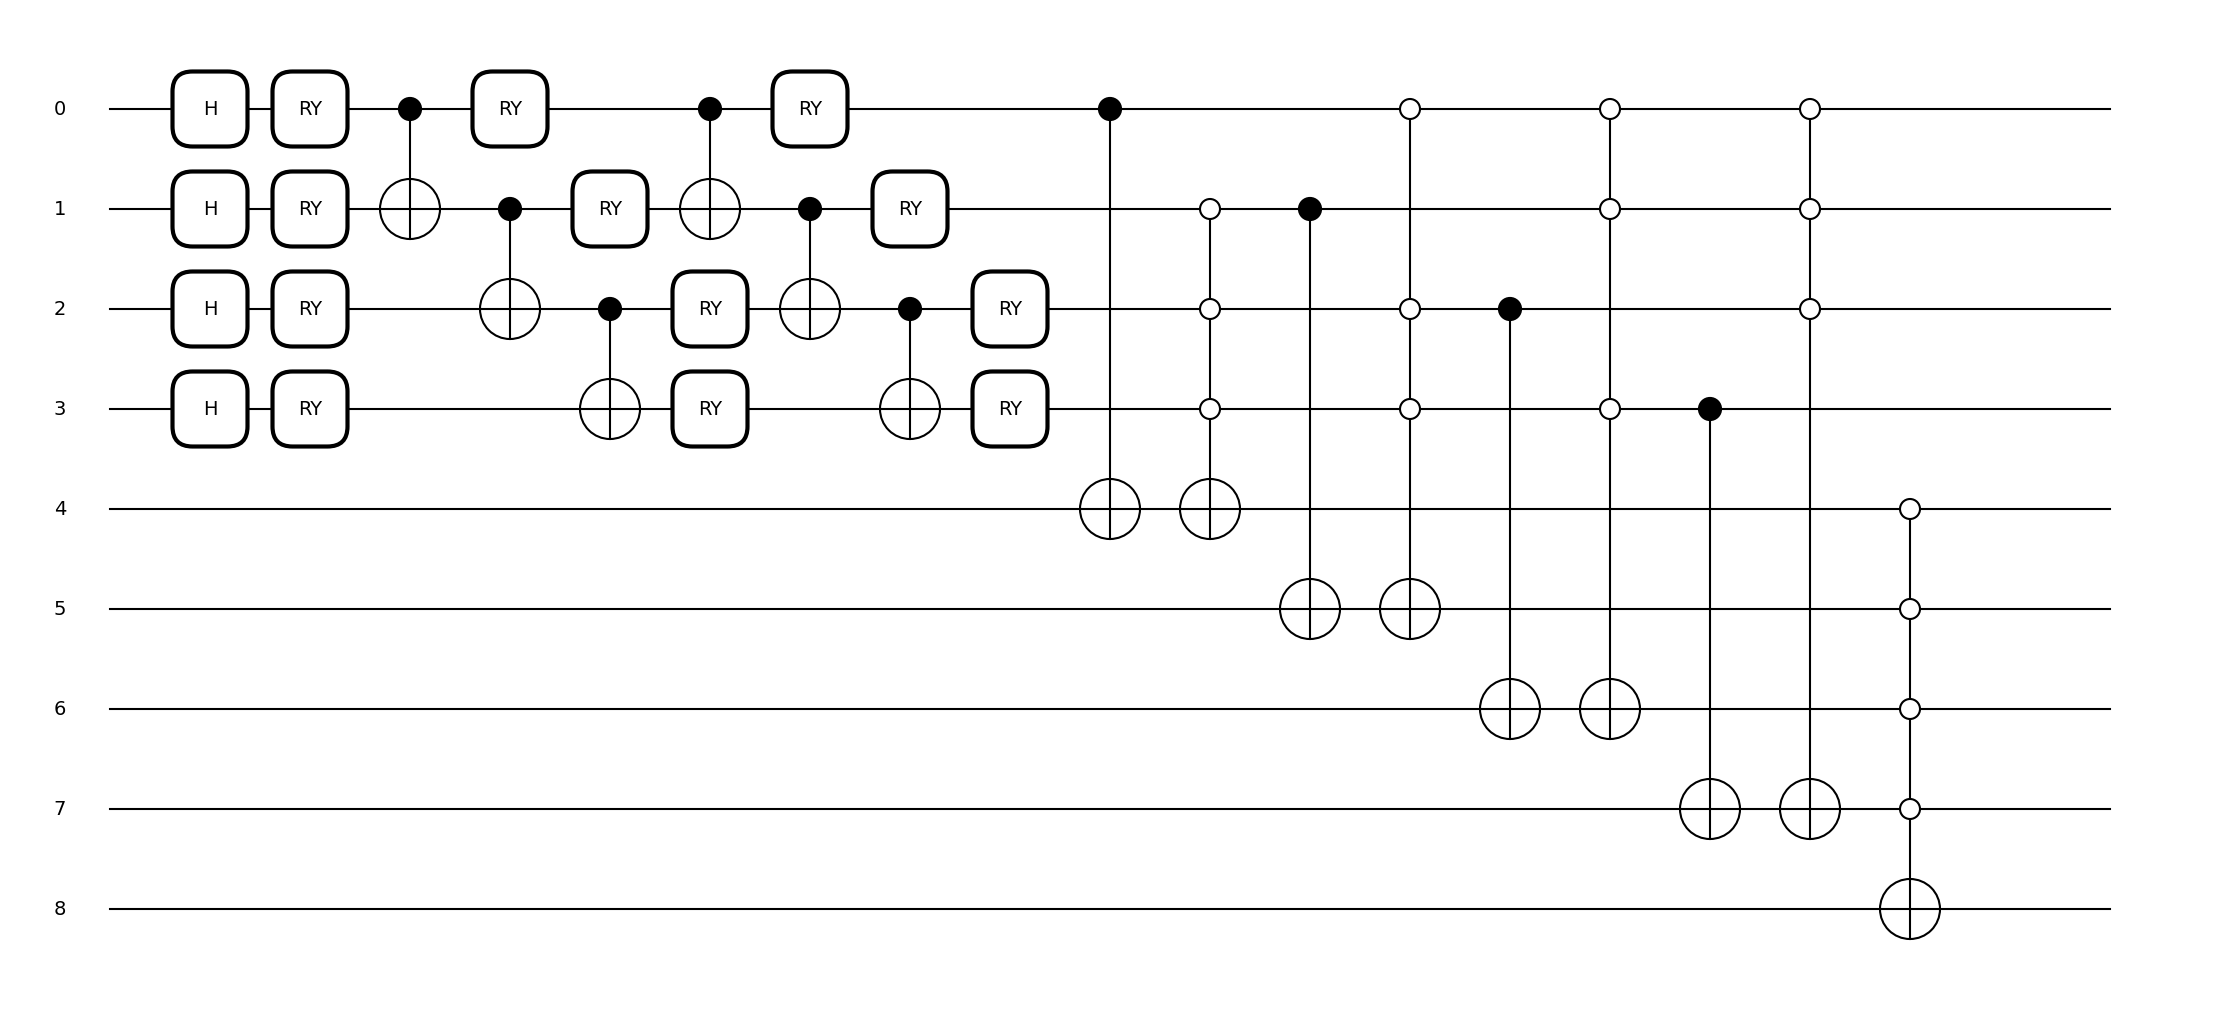

In [41]:
print(qml.draw_mpl(circuit)(G, params))

In [34]:
def cost(params, E_offset, e_tol, alpha):
    return (circuit(G, params)[0] + E_offset)*(-np.log(e_tol+(1-circuit(G, params)[1])/2) + alpha)

In [35]:
E_offset = 1
e_tol    = 1e-2
alpha    = 0.2

In [36]:
res = scipy.optimize.minimize(cost, x0=params, args = (E_offset, e_tol, alpha))

In [37]:
res # result of optimization 

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.19004966915411364
        x: [ 3.992e-01  6.901e-01  1.336e+00  1.513e+00  1.256e+00
             1.571e+00  1.511e+00  1.378e-02  2.491e+00  1.343e+00
            -2.426e-01 -1.571e+00]
      nit: 35
      jac: [-1.021e-06  5.178e-07  1.863e-07 -1.919e-07 -9.649e-07
            -7.860e-07 -3.725e-08 -1.058e-06  3.539e-07 -2.682e-07
            -2.906e-07 -3.297e-07]
 hess_inv: [[ 1.991e+01  1.684e+01 ... -1.058e+02  9.376e+01]
            [ 1.684e+01  1.676e+01 ... -9.322e+01  8.245e+01]
            ...
            [-1.058e+02 -9.322e+01 ...  6.000e+02 -5.347e+02]
            [ 9.376e+01  8.245e+01 ... -5.347e+02  4.780e+02]]
     nfev: 481
     njev: 37

In [38]:
params = res.x # set of optimized param

In [39]:
result_state = qml.snapshots(circuit)(G, params)[0] # final result state

In [40]:
circuit(G, params) # result of measurment with optimized params -> index 0: Hamiltonian, index 1: Z

tensor([ 1.76755077e-12, -1.00000000e+00], requires_grad=True)

# QAOA approach

In [42]:
n = num_qubits
dev = qml.device("default.qubit", wires=n)

def U_S_gate(G,x):    
    for i,node in enumerate(G.nodes):
        neighbors = list(G.neighbors(node))
        qml.ctrl(qml.RX, neighbors, control_values=[0]*len(neighbors))(x[i],wires=node)
        
def U_Sdg_gate(G,x):
    nodes = list(G.nodes)
    num_nodes = len(nodes)
    assert num_nodes == len(x)

    for i,node in enumerate(reversed(nodes)):
        neighbors = list(G.neighbors(node))
        qml.ctrl(qml.RX, neighbors, control_values=[0]*len(neighbors))(-x[num_nodes-1-i],wires=node)

def trotter_H_evolution(H):
    obs_groupings, coeffs_groupings = qml.pauli.group_observables(H.ops, H.coeffs, 'commuting', 'lf')
    
    commuting_h = []
    for i in range(len(obs_groupings)):
        commuting_h.append(qml.Hamiltonian(coeffs_groupings[i], obs_groupings[i], simplify=True))
    return commuting_h        
        
@qml.qnode(dev)
def QAOA_cost_fn(weights, G, depth, trotter_depth, hermitian_meas, h_prob, commuting_h_prob_list , return_expval=True):
    
    x = weights[:dev.num_wires] # Weight for rotations in U_S
    beta = weights[dev.num_wires : dev.num_wires + depth]
    gamma = weights[-depth:]
    
    U_S_gate(G,x)
    
    for d in range(depth):

        for _ in range(trotter_depth):
            for i in range(len(commuting_Hp_list)):
                #print(gamma[d], type(gamma[d]))
                qml.CommutingEvolution(commuting_Hp_list[i], gamma[d]/trotter_depth)
        
        U_Sdg_gate(G, x)
        for node in G.nodes:
            qml.PauliX(node)
        qml.ctrl(qml.PhaseShift, range(n-1), control_values=[1]*(n-1))(-beta[d],wires=n-1)
        for node in G.nodes:
            qml.PauliX(node)
        U_S_gate(G,x)
    
    if return_expval:
        return qml.expval(hermitian_meas)
    else:
        return qml.probs()

def cost_function(weights, *args):
    G,depth,trotter_depth,Q_plus_Qt,Q_plus_Qt_sq,commuting_Hp_list = args #= args[0], args[1], args[2], args[3], args[4], args[5]
    expval = QAOA_cost_fn(weights, G, depth, trotter_depth, Q_plus_Qt_sq, Q_plus_Qt, commuting_Hp_list)
    return expval

In [43]:
# Q_plus_Qt = create_Q_pm_Qt(G, is_plus=True)
# Q_plus_Qt_sq = create_H_squared(Q_plus_Qt)
# commuting_Hp_list = trotter_H_evolution(Q_plus_Qt)

H = generate_hamiltonian(G)
obs = qml.Hermitian(H, wires=range(n))
hamiltonian = qml.pauli_decompose(H)
commuting_Hp_list = trotter_H_evolution(hamiltonian)

In [44]:
depth = 3
trotter_depth = 3
weights = torch.tensor(np.random.rand(n+2*depth))
QAOA_cost_fn(weights, G, depth, trotter_depth, obs, hamiltonian, commuting_Hp_list)

tensor(2.00151109, requires_grad=True)

In [45]:
depth = 1
trotter_depth = 3
weights = torch.tensor(np.random.rand(n+2*depth))

args = (G, depth, trotter_depth, obs, hamiltonian, commuting_Hp_list)
res = scipy.optimize.minimize(cost_function, x0=weights, args=args)
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 7.901544990283213e-14
        x: [ 1.506e+00  6.244e-01 -2.857e-02  3.142e+00  2.114e-01
             1.298e+00]
      nit: 16
      jac: [ 2.049e-07 -5.468e-08  7.902e-08 -1.724e-08  9.335e-08
             2.728e-07]
 hess_inv: [[ 1.027e+00 -1.090e-01 ... -6.365e-02  1.124e-01]
            [-1.090e-01  1.091e+00 ...  2.710e-04  9.968e-02]
            ...
            [-6.365e-02  2.710e-04 ...  1.414e+00  9.855e-01]
            [ 1.124e-01  9.968e-02 ...  9.855e-01  9.157e-01]]
     nfev: 133
     njev: 19

In [46]:
state = QAOA_cost_fn(res.x, G, depth, trotter_depth, obs, hamiltonian, commuting_Hp_list, return_expval=False)
np.round(state,3)

tensor([0.   , 0.331, 0.   , 0.   , 0.042, 0.   , 0.   , 0.014, 0.6  ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.013, 0.   ], requires_grad=True)